In [1]:
import numpy as np
import seaborn as sns
import os
import sys
import matplotlib.pyplot as plt
from itertools import combinations
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from NNetwork import NNetwork as nn
from src.sampling.Sampling import sampling_sndl
from src.supervised_NDL.SNDL import sndl_equalEdge, sndl_predict
from util.plotting import *
from contextlib import contextmanager

In [2]:
@contextmanager
def suppress_output():
    # Redirect stdout to null
    with open(os.devnull, 'w') as fnull:
        original_stdout = sys.stdout
        sys.stdout = fnull
        try:
            yield
        finally:
            sys.stdout = original_stdout

## Binary Affinity Score Heatmap

In [3]:
def compute_latent_motifs_binary_all(graph_list, sample_size_list, k, xi, n_components, iterations, skip_folded_hom):
    motifs = {}
    for i, j in combinations(range(len(graph_list)), 2):
        print(f"Computing latent motifs for networks ({i}, {j})")
        X, y = sampling_sndl([graph_list[i], graph_list[j]], k=k, sample_size_list=sample_size_list, skip_folded_hom=skip_folded_hom)
        with suppress_output():
            W, beta, H = sndl_equalEdge([graph_list[i], graph_list[j]], sample_size_list, k=k, xi=xi, 
                                        n_components=n_components, iter=iterations, skip_folded_hom=skip_folded_hom)
        motifs[(i, j)] = (W, beta)
    return motifs

In [4]:
def compute_affinity_scores(motifs, graph_paths):
    affinity_scores = {}
    num_graphs = len(graph_paths)
    
    for (i, j), (W, beta) in motifs.items():
        for l in range(num_graphs):
            print(f"Computing affinity score for pair ({i}, {j}) with test network {l}")
            G_test = nn.NNetwork()
            G_test.load_add_edges(graph_paths[l], increment_weights=False, use_genfromtxt=True)
            affinity_score = sndl_predict(G_test, W, beta, 1000)
            affinity_scores[(i, j, l)] = affinity_score
            del G_test  # Clear memory after usage
    return affinity_scores

In [5]:
def plot_affinity_heatmap_binary_all(affinity_scores, ntwk_list):
    num_graphs = len(ntwk_list)
    num_pairs = len(list(combinations(range(num_graphs), 2)))
    affinity_matrix = np.zeros((num_pairs, num_graphs))
    
    row_labels = []
    idx = 0
    
    for i, j in combinations(range(num_graphs), 2):
        row_labels.append(f'{ntwk_list[i]} & {ntwk_list[j]}')
        for l in range(num_graphs):
            affinity_matrix[idx, l] = affinity_scores[(i, j, l)][1]
        idx += 1

    col_labels = [ntwk for ntwk in ntwk_list]

    plt.figure(figsize=(10, 8))
    sns.heatmap(affinity_matrix, annot=True, fmt=".2f", xticklabels=col_labels, yticklabels=row_labels, cmap='Blues')
    plt.xlabel('Test Network')
    plt.ylabel('Network Pair')
    plt.title('Affinity Scores Heatmap')
    plt.show()

In [6]:
def affinity_analysis_binary_all(ntwk_list, sample_size_list, k, xi, n_components, iterations, skip_folded_hom):
    graph_paths = [f"data/{ntwk}.txt" for ntwk in ntwk_list]
    graph_list = []

    for path in graph_paths:
        G = nn.NNetwork()
        G.load_add_edges(path, increment_weights=False, use_genfromtxt=True)
        graph_list.append(G)
    
    motifs = compute_latent_motifs_binary_all(graph_list, sample_size_list, k, xi, n_components, iterations, skip_folded_hom)
    affinity_scores = compute_affinity_scores(motifs, graph_paths)
    plot_affinity_heatmap_binary_all(affinity_scores, ntwk_list)

Computing latent motifs for networks (0, 1)
num of subgraphs induced on k-paths: 500
num of subgraphs induced on k-paths: 500


100%|██████████| 250/250 [00:09<00:00, 25.87it/s]


Computing latent motifs for networks (0, 2)
num of subgraphs induced on k-paths: 500
num of subgraphs induced on k-paths: 500


100%|██████████| 250/250 [00:29<00:00,  8.49it/s]


Computing latent motifs for networks (0, 3)
num of subgraphs induced on k-paths: 500
num of subgraphs induced on k-paths: 500


100%|██████████| 250/250 [00:21<00:00, 11.57it/s]


Computing latent motifs for networks (1, 2)
num of subgraphs induced on k-paths: 500
num of subgraphs induced on k-paths: 500


100%|██████████| 250/250 [00:12<00:00, 19.76it/s]


Computing latent motifs for networks (1, 3)
num of subgraphs induced on k-paths: 500
num of subgraphs induced on k-paths: 500


100%|██████████| 250/250 [00:09<00:00, 25.21it/s]


Computing latent motifs for networks (2, 3)
num of subgraphs induced on k-paths: 500
num of subgraphs induced on k-paths: 500


100%|██████████| 250/250 [00:11<00:00, 21.89it/s]


Computing affinity score for pair (0, 1) with test network 0
Computing affinity score for pair (0, 1) with test network 1
Computing affinity score for pair (0, 1) with test network 2
Computing affinity score for pair (0, 1) with test network 3
Computing affinity score for pair (0, 2) with test network 0
Computing affinity score for pair (0, 2) with test network 1
Computing affinity score for pair (0, 2) with test network 2
Computing affinity score for pair (0, 2) with test network 3
Computing affinity score for pair (0, 3) with test network 0
Computing affinity score for pair (0, 3) with test network 1
Computing affinity score for pair (0, 3) with test network 2
Computing affinity score for pair (0, 3) with test network 3
Computing affinity score for pair (1, 2) with test network 0
Computing affinity score for pair (1, 2) with test network 1
Computing affinity score for pair (1, 2) with test network 2
Computing affinity score for pair (1, 2) with test network 3
Computing affinity score

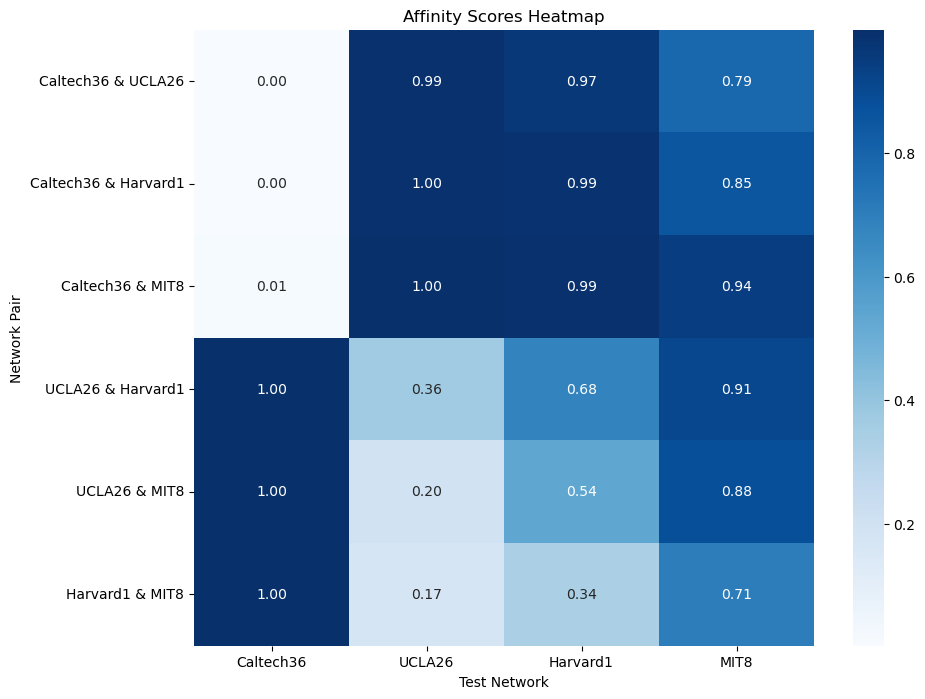

In [7]:
# Example usage
ntwk_list = ['Caltech36', 'UCLA26', 'Harvard1', "MIT8"]
sample_size_list = [500, 500]
k = 50
n_components = 16
iterations = 250

affinity_analysis_binary_all(ntwk_list, sample_size_list, k, n_components, iterations)

Computing latent motifs for networks (0, 1)


100%|██████████| 250/250 [00:13<00:00, 19.04it/s]


Computing latent motifs for networks (0, 2)


100%|██████████| 250/250 [00:18<00:00, 13.74it/s]


Computing latent motifs for networks (0, 3)


100%|██████████| 250/250 [00:24<00:00, 10.30it/s]


Computing latent motifs for networks (0, 4)


100%|██████████| 250/250 [00:22<00:00, 11.35it/s]


Computing latent motifs for networks (1, 2)


100%|██████████| 250/250 [00:20<00:00, 12.31it/s]


Computing latent motifs for networks (1, 3)


100%|██████████| 250/250 [00:23<00:00, 10.48it/s]


Computing latent motifs for networks (1, 4)


100%|██████████| 250/250 [00:21<00:00, 11.67it/s]


Computing latent motifs for networks (2, 3)


100%|██████████| 250/250 [00:22<00:00, 11.20it/s]


Computing latent motifs for networks (2, 4)


100%|██████████| 250/250 [00:15<00:00, 15.92it/s]


Computing latent motifs for networks (3, 4)


100%|██████████| 250/250 [00:12<00:00, 20.48it/s]


Computing affinity score for pair (0, 1) with test network 0
Computing affinity score for pair (0, 1) with test network 1
Computing affinity score for pair (0, 1) with test network 2
Computing affinity score for pair (0, 1) with test network 3
Computing affinity score for pair (0, 1) with test network 4
Computing affinity score for pair (0, 2) with test network 0
Computing affinity score for pair (0, 2) with test network 1
Computing affinity score for pair (0, 2) with test network 2
Computing affinity score for pair (0, 2) with test network 3
Computing affinity score for pair (0, 2) with test network 4
Computing affinity score for pair (0, 3) with test network 0
Computing affinity score for pair (0, 3) with test network 1
Computing affinity score for pair (0, 3) with test network 2
Computing affinity score for pair (0, 3) with test network 3
Computing affinity score for pair (0, 3) with test network 4
Computing affinity score for pair (0, 4) with test network 0
Computing affinity score

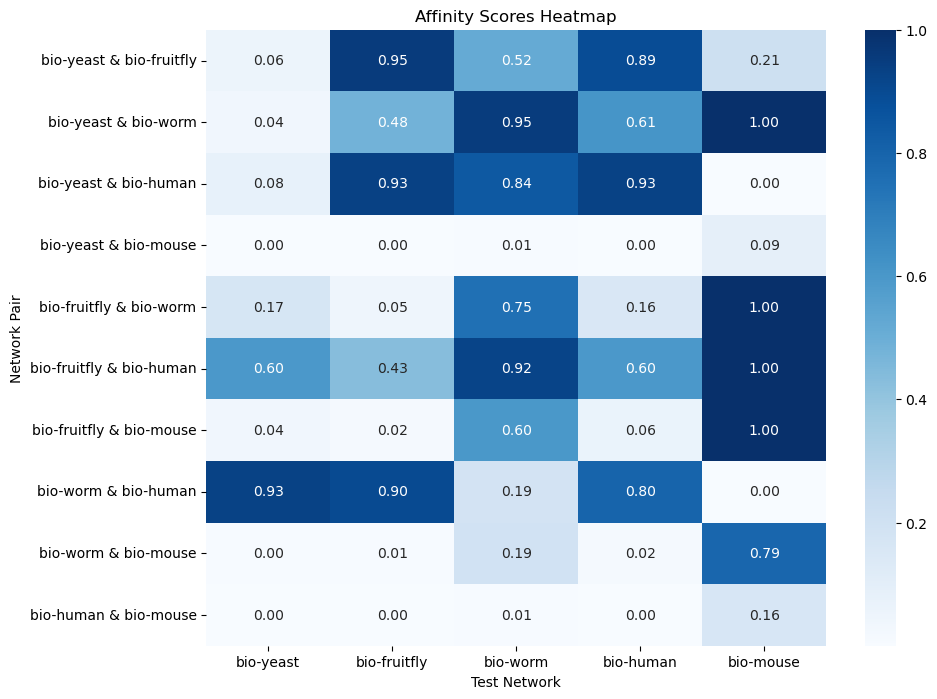

In [8]:
# Biological Experiment
ntwk_list = ['bio-yeast', 'bio-fruitfly', 'bio-worm', 'bio-human', 'bio-mouse']
sample_size_list = [300, 300]
k = 60
xi = 7
n_components = 16
iterations = 250
skip_folded_hom = False

affinity_analysis_binary_all(ntwk_list, sample_size_list, k, xi, n_components, 
                             iterations, skip_folded_hom)